# Entry G13: Weighted Degree Comparison

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('once')

from neo4j import GraphDatabase

In [3]:
uri = "bolt://localhost:7687"

driver = GraphDatabase.driver(uri, auth=('neo4j', 'password'))

uni_session = driver.session(database="unimodal")
bi_session = driver.session(database="bimodal")
mix_session = driver.session(database="mixmodal")

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Weighted Degree Count

### Unimodal Model

In [4]:
uni_session.run('''MATCH ()-[r]-()
With distinct(r)
RETURN sum(r.weight) as weighted_degree''').data()

[{'weighted_degree': 579171}]

### Bimodal Model

### Mixed Model

In [9]:
mix_session.run('''MATCH ()-[r]-()
With distinct(r)
RETURN sum(r.weight) as weighted_degree''').data()

[{'weighted_degree': 579039}]

## Weighted Degree Summary Statistics

### Unimodal Model

In [5]:
uni_session.run('''MATCH (n)-[r]-(m)
with n.name as hero, sum(r.weight) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 1,
  'weighted_degree_max': 16057,
  'weighted_degree_avg': 180.4,
  'weighted_degree_stdev': 728.32}]

In [6]:
uni_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
    KNOWS: {
      type: 'KNOWS',
      orientation:'UNDIRECTED',
      properties:'weight'
  }},
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 0.0,
  'weighted_degree_max': 16057.0,
  'weighted_degree_avg': 179.89,
  'weighted_degree_stdev': 727.36}]

### Bimodal Model

**Hero to Hero**

In [30]:
# These seem a bit high. Are you calculating the weighted degree correctly??

bi_session.run('''MATCH (h:Hero)--(c:Comic)--(h2:Hero)
WITH h.name as hero, count(c) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 1,
  'weighted_degree_max': 16057,
  'weighted_degree_avg': 180.4,
  'weighted_degree_stdev': 728.32}]

**Comic to Comic**

In [33]:
bi_session.run('''MATCH (c:Comic)--(h:Hero)--(c2:Comic)
WITH c.name as comic, count(h) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 1,
  'weighted_degree_max': 27582,
  'weighted_degree_avg': 1895.96,
  'weighted_degree_stdev': 2119.59}]

### Mixed Model

Change these. I want Hero to Hero and Comic to Comic.

And why are the results different anyway??

In [14]:
mix_session.run('''MATCH (n)-[r]-(m)
with n.name as hero, sum(r.weight) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 0,
  'weighted_degree_max': 16054,
  'weighted_degree_avg': 60.66,
  'weighted_degree_stdev': 430.82}]

In [15]:
mix_session.run('''MATCH (n)-[r:KNOWS]-(m)
with n.name as hero, sum(r.weight) as weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 1,
  'weighted_degree_max': 16054,
  'weighted_degree_avg': 180.36,
  'weighted_degree_stdev': 728.2}]

In [16]:
mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
    KNOWS: {
      type: 'KNOWS',
      orientation:'UNDIRECTED',
      properties:'weight'
  }},
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
WITH gds.util.asNode(nodeId).name AS hero, score AS weighted_degree
RETURN min(weighted_degree) as weighted_degree_min,
max(weighted_degree) as weighted_degree_max,
round(avg(weighted_degree)*100)/100 as weighted_degree_avg,
round(stdev(weighted_degree)*100)/100 as weighted_degree_stdev''').data()

[{'weighted_degree_min': 0.0,
  'weighted_degree_max': 16054.0,
  'weighted_degree_avg': 179.85,
  'weighted_degree_stdev': 727.25}]

## Weighted Degree Distribution

In [7]:
uni_weighted_df = pd.DataFrame(uni_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
    KNOWS: {
      type: 'KNOWS',
      orientation:'UNDIRECTED',
      properties:'weight'
  }},
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS hero, score AS weighted_degree''').values(), columns=['hero', 'weighted_degree'])

uni_weighted_df.head()

,hero,weighted_degree
0,24-HOUR MAN/EMMANUEL,5.0
1,3-D MAN/CHARLES CHAN,148.0
2,4-D MAN/MERCURIO,118.0
3,8-BALL/,21.0
4,"ABBOTT, JACK",8.0


In [21]:
bi_weighted_hero2hero = pd.DataFrame(bi_session.run('''MATCH (h:Hero)--(c:Comic)--(h2:Hero)
RETURN h.name as hero, count(c) as weighted_degree
ORDER BY hero''').data())
weighted_hero2hero.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,hero,weighted_degree
0,24-HOUR MAN/EMMANUEL,5
1,3-D MAN/CHARLES CHAN,148
2,4-D MAN/MERCURIO,118
3,8-BALL/,21
4,A,17


In [22]:
bi_weighted_comic2comic = pd.DataFrame(bi_session.run('''MATCH (c:Comic)--(h:Hero)--(c2:Comic)
RETURN c.name as comic, count(h) as weighted_degree
ORDER BY comic''').data())
bi_weighted_comic2comic.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comic,weighted_degree
0,2001 10,58
1,2001 8,58
2,2001 9,58
3,A '00,4053
4,A '01,1783


In [26]:
mixed_weighted_hero2hero = pd.DataFrame(mix_session.run('''CALL gds.alpha.degree.stream({
  nodeProjection: 'Hero',
  relationshipProjection: {
    KNOWS: {
      type: 'KNOWS',
      orientation:'UNDIRECTED',
      properties:'weight'
  }},
  relationshipWeightProperty: 'weight'
})
YIELD nodeId, score
RETURN gds.util.asNode(nodeId).name AS hero, score AS weighted_degree''').values(), columns=['hero', 'weighted_degree'])

mixed_weighted_hero2hero.head()

,hero,weighted_degree
0,24-HOUR MAN/EMMANUEL,5.0
1,3-D MAN/CHARLES CHAN,148.0
2,4-D MAN/MERCURIO,118.0
3,8-BALL/,21.0
4,"ABBOTT, JACK",8.0


In [27]:
# Figure out how to project this using the gds algo?

mixed_weighted_comic2comic = pd.DataFrame(mix_session.run('''MATCH (c:Comic)--(h:Hero)--(c2:Comic)
RETURN c.name as comic, count(h) as weighted_degree
ORDER BY comic''').data())
mixed_weighted_comic2comic.head()

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,comic,weighted_degree
0,2001 10,58
1,2001 8,58
2,2001 9,58
3,A '00,4053
4,A '01,1783


### Unimodal Model

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


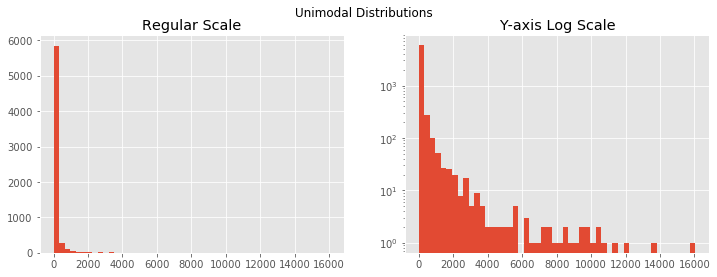

In [8]:
uni_fig, (uni_ax1, uni_ax2) = plt.subplots(1, 2, figsize=(12,4))
uni_fig.suptitle("Unimodal Distributions")
uni_ax1.hist(uni_weighted_df['weighted_degree'], bins=50)
uni_ax1.set_title('Regular Scale')
uni_ax2.hist(uni_weighted_df['weighted_degree'], bins=50)
uni_ax2.set_yscale('log')
uni_ax2.set_title('Y-axis Log Scale')
plt.show()

### Bimodal Model

**Hero to Hero**

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


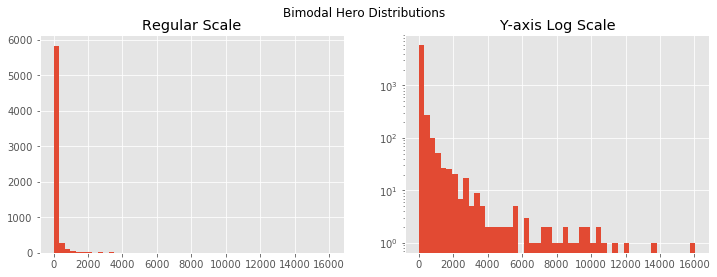

In [23]:
bih_fig, (bih_ax1, bih_ax2) = plt.subplots(1, 2, figsize=(12,4))
bih_fig.suptitle("Bimodal Hero Distributions")
bih_ax1.hist(bi_weighted_hero2hero['weighted_degree'], bins=50)
bih_ax1.set_title('Regular Scale')
bih_ax2.hist(bi_weighted_hero2hero['weighted_degree'], bins=50)
bih_ax2.set_yscale('log')
bih_ax2.set_title('Y-axis Log Scale')
plt.show()

**Comic to Comic**

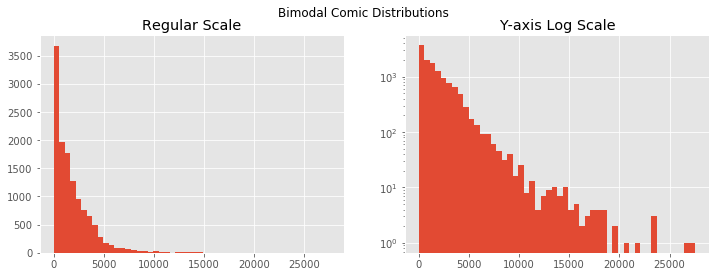

In [24]:
bic_fig, (bic_ax1, bic_ax2) = plt.subplots(1, 2, figsize=(12,4))
bic_fig.suptitle("Bimodal Comic Distributions")
bic_ax1.hist(bi_weighted_comic2comic['weighted_degree'], bins=50)
bic_ax1.set_title('Regular Scale')
bic_ax2.hist(bi_weighted_comic2comic['weighted_degree'], bins=50)
bic_ax2.set_yscale('log')
bic_ax2.set_title('Y-axis Log Scale')
plt.show()

### Mixed Model

**Hero to Hero**

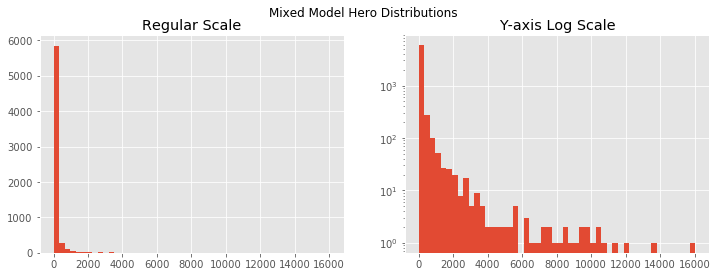

In [29]:
mixh_fig, (mixh_ax1, mixh_ax2) = plt.subplots(1, 2, figsize=(12,4))
mixh_fig.suptitle("Mixed Model Hero Distributions")
mixh_ax1.hist(mixed_weighted_hero2hero['weighted_degree'], bins=50)
mixh_ax1.set_title('Regular Scale')
mixh_ax2.hist(mixed_weighted_hero2hero['weighted_degree'], bins=50)
mixh_ax2.set_yscale('log')
mixh_ax2.set_title('Y-axis Log Scale')
plt.show()

**Comic to Comic**

//anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


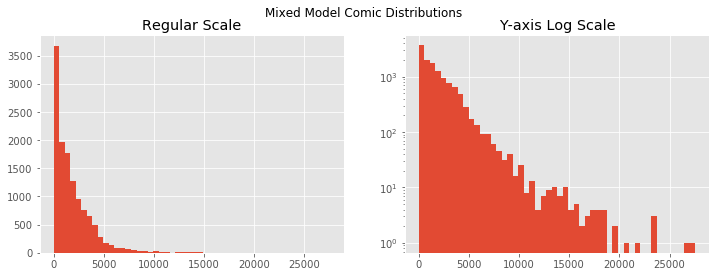

In [28]:
mixc_fig, (mixc_ax1, mixc_ax2) = plt.subplots(1, 2, figsize=(12,4))
mixc_fig.suptitle("Mixed Model Comic Distributions")
mixc_ax1.hist(mixed_weighted_comic2comic['weighted_degree'], bins=50)
mixc_ax1.set_title('Regular Scale')
mixc_ax2.hist(mixed_weighted_comic2comic['weighted_degree'], bins=50)
mixc_ax2.set_yscale('log')
mixc_ax2.set_title('Y-axis Log Scale')
plt.show()